# Naive Bayes news

In [19]:
%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow gensim ipykernel jinja2
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
%pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Instalacja wszystkich potrzebnych pakietów

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported!")


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.9 -m pip ins

In [20]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(14, 10), 
                          cmap='Blues', fontsize_title=16, fontsize_labels=12):
    from sklearn.utils.multiclass import unique_labels
    
    labels = list(unique_labels(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Number of samples'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(title, fontsize=fontsize_title, pad=20)
    plt.xlabel('Predicted Category', fontsize=fontsize_labels)
    plt.ylabel('Actual Category', fontsize=fontsize_labels)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def display_classification_metrics(y_true, y_pred, model_name='Model'):
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    results = []
    for label in sorted(report.keys()):
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            results.append({
                'Category': label,
                'Precision': f"{report[label]['precision']:.4f}",
                'Recall': f"{report[label]['recall']:.4f}",
                'F1-Score': f"{report[label]['f1-score']:.4f}"
            })
    
    df = pd.DataFrame(results)
    df['Precision'] = pd.to_numeric(df['Precision'])
    df['Recall'] = pd.to_numeric(df['Recall'])
    df['F1-Score'] = pd.to_numeric(df['F1-Score'])
    
    styled_df = df.style.format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}'
    }).background_gradient(subset=['Precision', 'Recall', 'F1-Score'], cmap='YlGnBu', vmin=0, vmax=1).set_caption(f'Overall Accuracy: {accuracy:.2f}%').set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    
    display(styled_df)


In [21]:
file_path = 'news/labeled_1000_with_sport.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Number of articles: {len(data)}")

Number of articles: 7000


In [22]:
texts = []
labels = []

for article in data:
    texts.append(article['text'])
    labels.append(article['label'])

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train)} articles")
print(f"Test set: {len(X_test)} articles")
print(f"Categories in training set: {Counter(y_train)}")


Training set: 5600 articles
Test set: 1400 articles
Categories in training set: Counter({'World': 800, 'Health': 800, 'Politics': 800, 'sport': 800, 'Business': 800, 'Culture': 800, 'Technology': 800})


In [23]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


In [24]:
print("Predicting categories for test set...")
predictions = classifier.predict(X_test)

display_classification_metrics(y_test, predictions)


Predicting categories for test set...


,Category,Precision,Recall,F1-Score
0,Business,0.8247,0.8000,0.8122
1,Culture,0.7783,0.8950,0.8326
2,Health,0.8312,0.9600,0.8910
3,Politics,0.9430,0.7450,0.8324
4,Technology,0.7746,0.8250,0.7990
5,World,0.9368,0.8150,0.8717
6,sport,0.9850,0.9850,0.9850


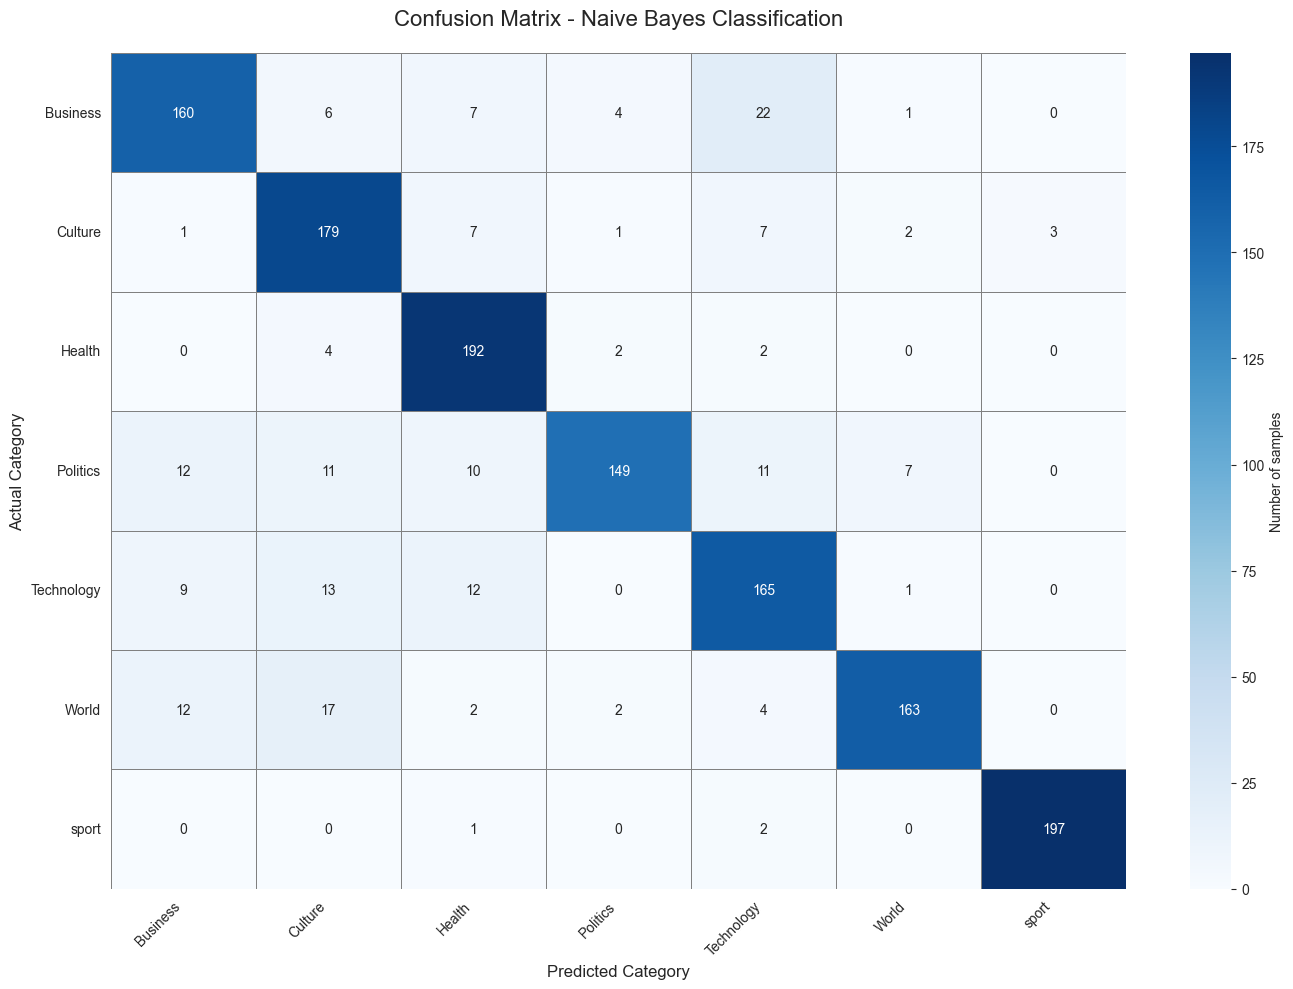

In [25]:
plot_confusion_matrix(y_test, predictions, title='Confusion Matrix - Naive Bayes Classification')


# LinearSVC


In [26]:
linear_svc_classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', LinearSVC(random_state=42, max_iter=1000))
])

linear_svc_classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(linear_svc_classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
svc_predictions = linear_svc_classifier.predict(X_test)

display_classification_metrics(y_test, svc_predictions)


,Category,Precision,Recall,F1-Score
0,Business,0.7228,0.7300,0.7264
1,Culture,0.7552,0.7250,0.7398
2,Health,0.8365,0.8700,0.8529
3,Politics,0.8034,0.7150,0.7566
4,Technology,0.6849,0.7500,0.7160
5,World,0.8513,0.8300,0.8405
6,sport,0.9515,0.9800,0.9655


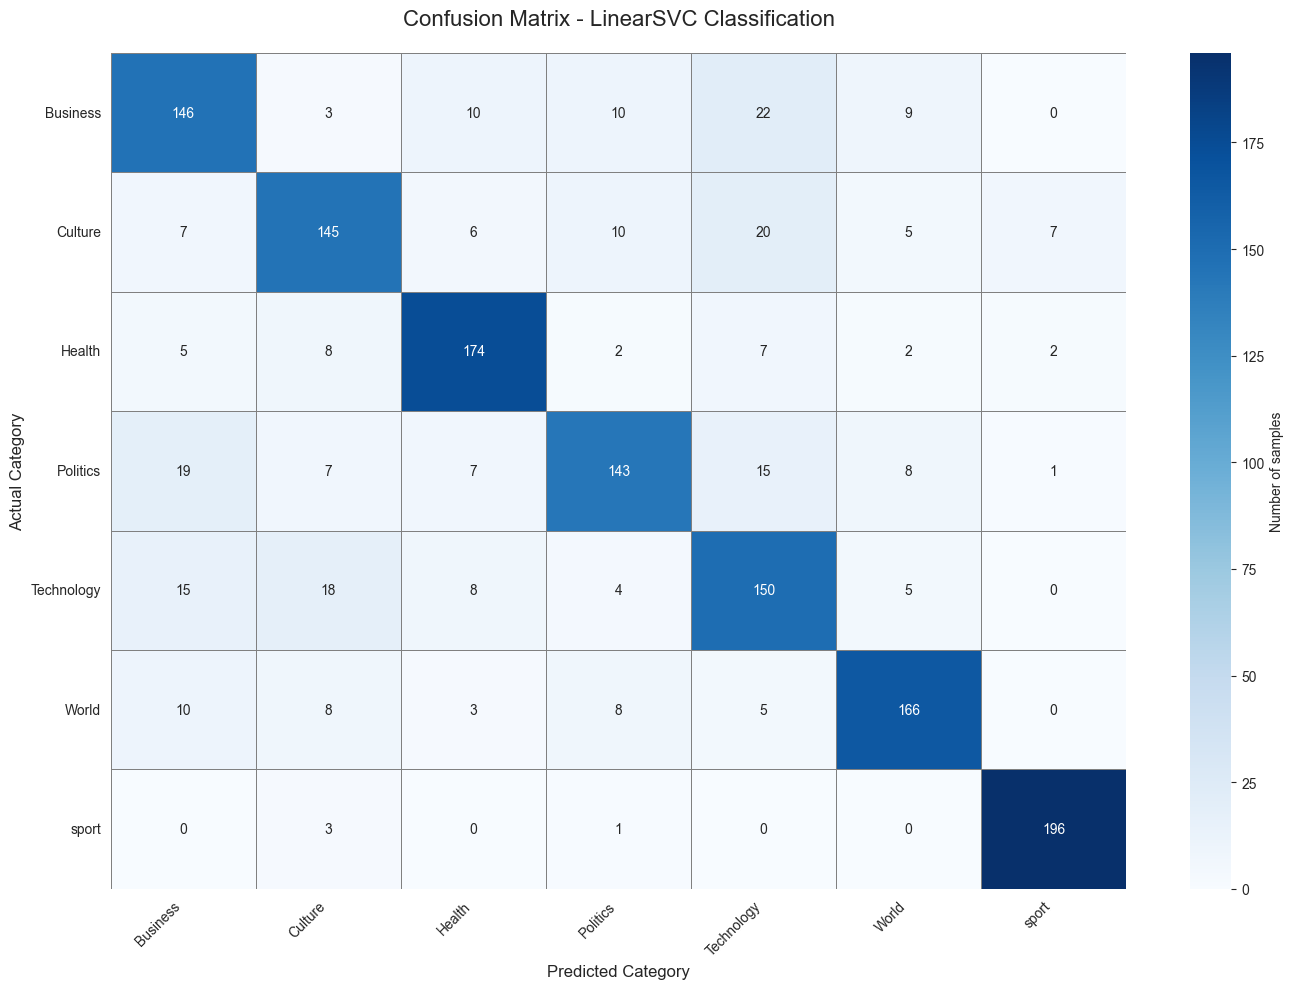

In [28]:
plot_confusion_matrix(y_test, svc_predictions, title='Confusion Matrix - LinearSVC Classification')


# CNN (Conv1D)


In [29]:
print("="*80)
print("CNN (CONV1D) CLASSIFIER FOR TEXT")
print("="*80)
print("\nPreparing data for CNN...")

max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Vocabulary size: {max_words}")
print(f"Sequence length: {max_len}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train_padded)}")
print(f"Test samples: {len(X_test_padded)}")


CNN (CONV1D) CLASSIFIER FOR TEXT

Preparing data for CNN...
Vocabulary size: 10000
Sequence length: 500
Number of classes: 7
Training samples: 5600
Test samples: 1400


In [30]:
embedding_dim = 128

cnn_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
print("\nTraining CNN classifier...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_padded, y_train_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("✓ Trained!")



Training CNN classifier...
Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.2068 - loss: 1.8973 - val_accuracy: 0.5366 - val_loss: 1.3511
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5303 - loss: 1.2596 - val_accuracy: 0.6464 - val_loss: 0.9404
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7162 - loss: 0.8289 - val_accuracy: 0.7437 - val_loss: 0.7128
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8539 - loss: 0.4958 - val_accuracy: 0.7714 - val_loss: 0.6343
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9307 - loss: 0.2772 - val_accuracy: 0.7679 - val_loss: 0.6303
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9646 - loss: 0.1661 - val_accuracy: 0.7768 - val_loss: 0.6498
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9770 - loss: 0.1063 - val_accuracy: 0.7705 - val_loss: 0.6802
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.98

In [32]:
cnn_predictions_proba = cnn_model.predict(X_test_padded, verbose=0)
cnn_predictions_encoded = np.argmax(cnn_predictions_proba, axis=1)
cnn_predictions = label_encoder.inverse_transform(cnn_predictions_encoded)

display_classification_metrics(y_test, cnn_predictions)


,Category,Precision,Recall,F1-Score
0,Business,0.7541,0.6900,0.7206
1,Culture,0.7186,0.8300,0.7703
2,Health,0.8155,0.8400,0.8276
3,Politics,0.8393,0.7050,0.7663
4,Technology,0.7110,0.7750,0.7416
5,World,0.8256,0.8050,0.8152
6,sport,0.9799,0.9750,0.9774


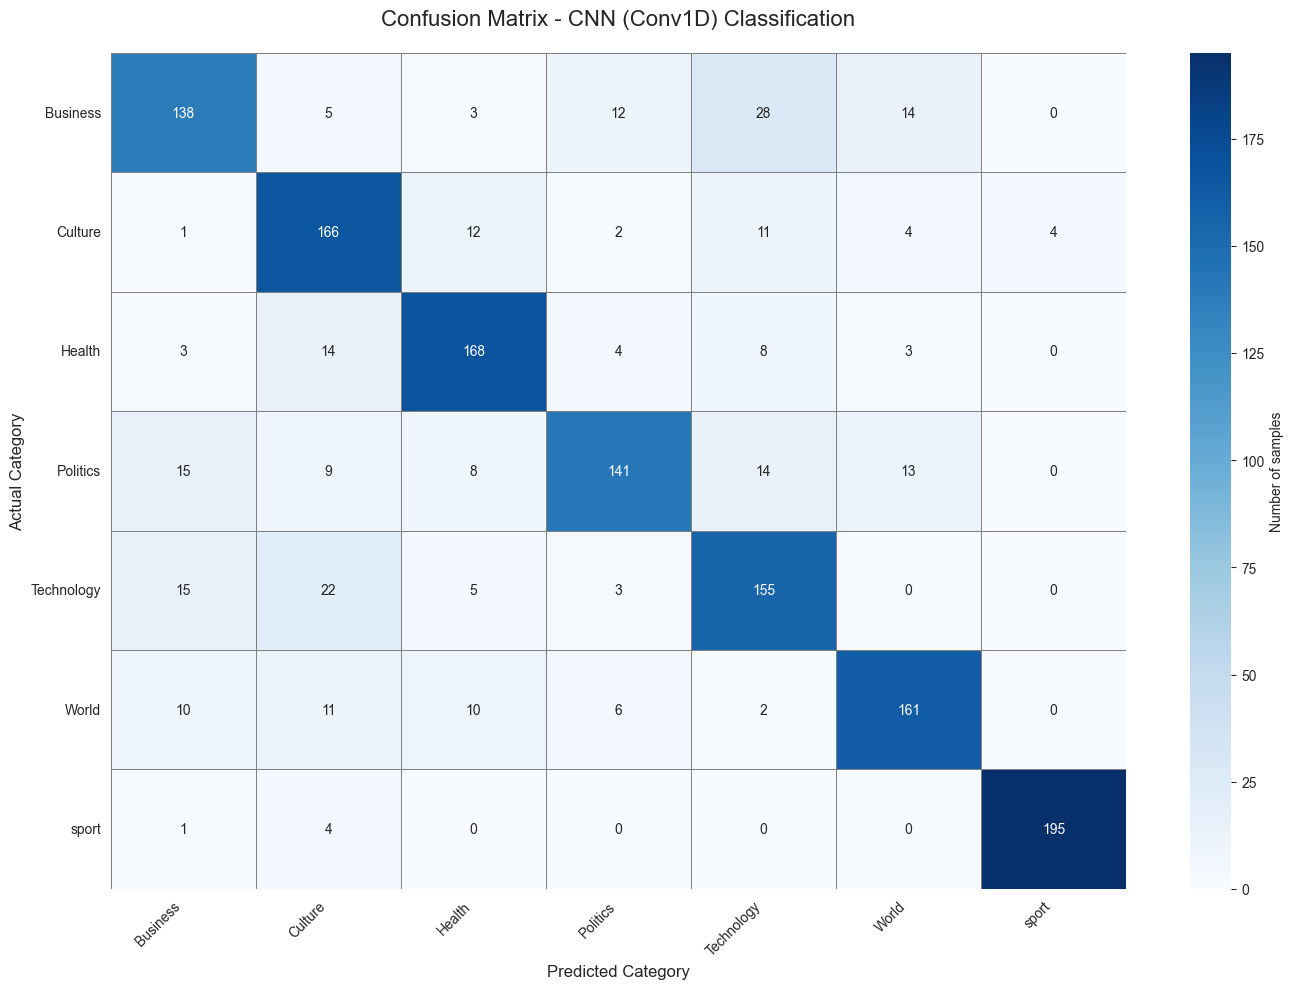

In [33]:
plot_confusion_matrix(y_test, cnn_predictions, title='Confusion Matrix - CNN (Conv1D) Classification')


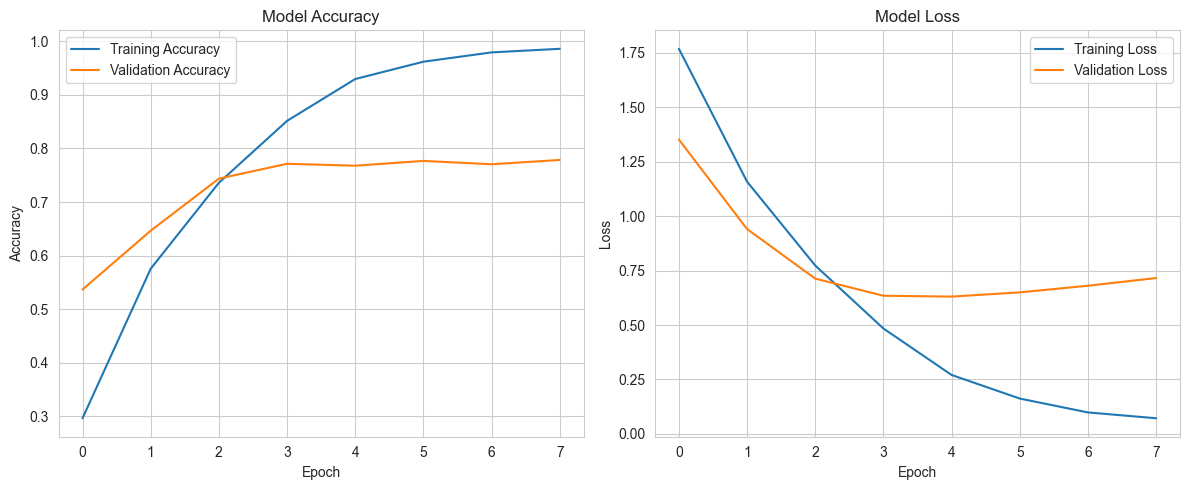

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Dense Neural Network for Text Classification


In [35]:
print("="*80)
print("DENSE NEURAL NETWORK CLASSIFIER FOR TEXT")
print("="*80)
print("\nBuilding Dense NN model...")

embedding_dim_dense = 128

dense_model = Sequential([
    Embedding(max_words, embedding_dim_dense, input_length=max_len),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

dense_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


DENSE NEURAL NETWORK CLASSIFIER FOR TEXT

Building Dense NN model...


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
print("\nTraining Dense NN classifier...")

early_stopping_dense = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_dense = dense_model.fit(
    X_train_padded, y_train_categorical,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_dense],
    verbose=1
)

print("✓ Trained!")



Training Dense NN classifier...
Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.1937 - loss: 1.9179 - val_accuracy: 0.3848 - val_loss: 1.4966
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3958 - loss: 1.4783 - val_accuracy: 0.5179 - val_loss: 1.2668
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6318 - loss: 0.9434 - val_accuracy: 0.6366 - val_loss: 1.0742
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8265 - loss: 0.5493 - val_accuracy: 0.6875 - val_loss: 0.9699
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.9312 - loss: 0.2586 - val_accuracy: 0.7045 - val_loss: 0.9423
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.9582 - loss: 0.1635 - val_accuracy: 0.7036 - val_loss: 1.0342
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.9759 - loss: 0.1207 - val_accuracy: 0.7063 - val_loss: 1.1278
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/

In [37]:
dense_predictions_proba = dense_model.predict(X_test_padded, verbose=0)
dense_predictions_encoded = np.argmax(dense_predictions_proba, axis=1)
dense_predictions = label_encoder.inverse_transform(dense_predictions_encoded)

display_classification_metrics(y_test, dense_predictions)


,Category,Precision,Recall,F1-Score
0,Business,0.6453,0.7550,0.6959
1,Culture,0.7000,0.4900,0.5765
2,Health,0.7020,0.8600,0.7730
3,Politics,0.7977,0.6900,0.7399
4,Technology,0.6008,0.7300,0.6591
5,World,0.8797,0.6950,0.7765
6,sport,0.9420,0.9750,0.9582


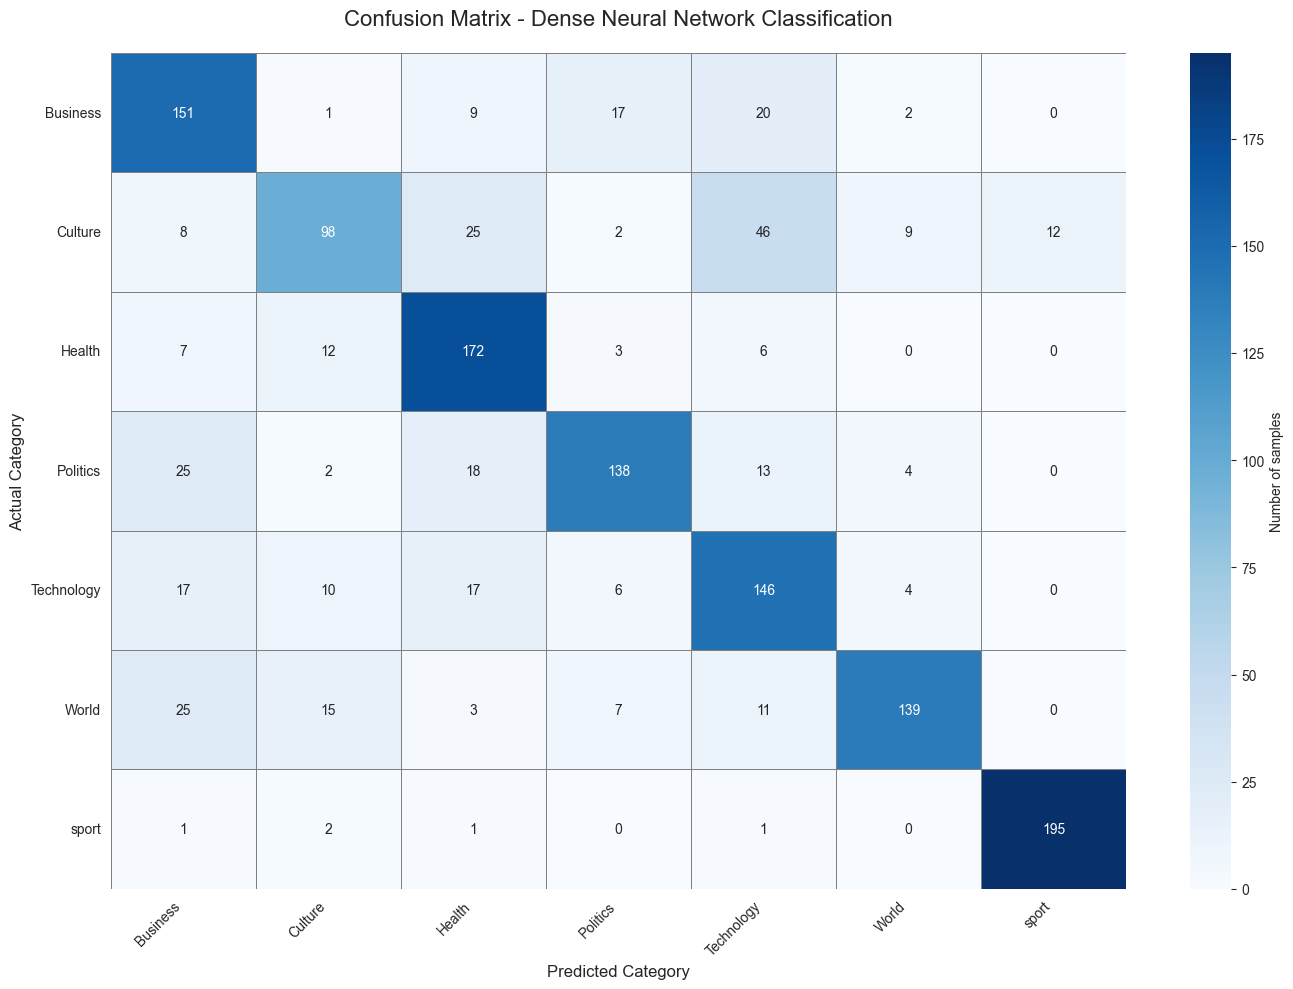

In [38]:
plot_confusion_matrix(y_test, dense_predictions, title='Confusion Matrix - Dense Neural Network Classification')


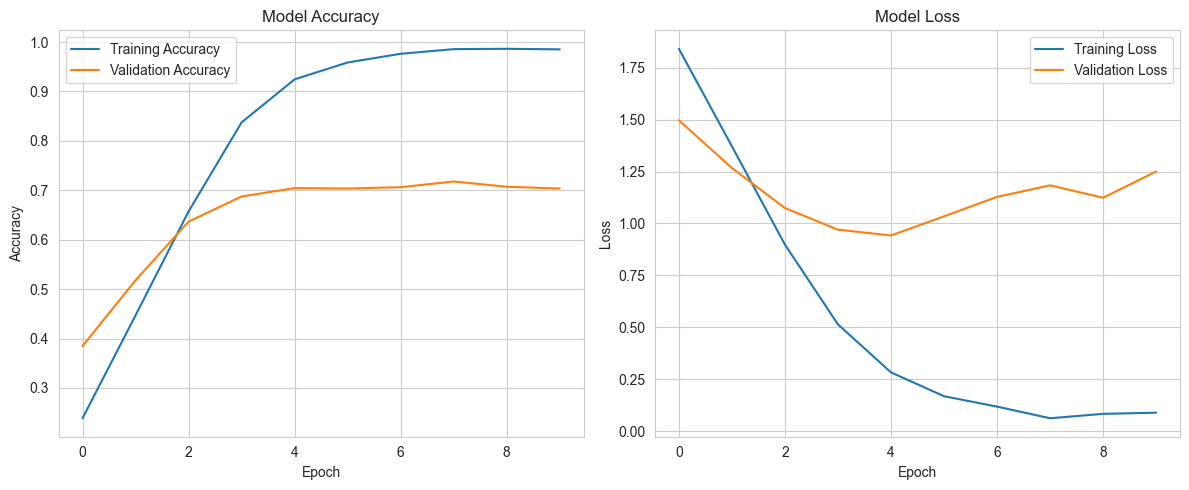

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dense.history['accuracy'], label='Training Accuracy')
plt.plot(history_dense.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_dense.history['loss'], label='Training Loss')
plt.plot(history_dense.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Word Importance Analysis


In [40]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - NAIVE BAYES")
print("="*80)

vectorizer = classifier.named_steps['vectorizer']
nb_model = classifier.named_steps['classifier']
vocabulary = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names_out()

feature_log_prob = nb_model.feature_log_prob_
classes = nb_model.classes_

print(f"\nNumber of categories: {len(classes)}")
print(f"Number of words (features): {len(feature_names)}")

nb_top_words = {}
for i, category in enumerate(classes):
    other_categories_log_probs = np.mean(
        np.delete(feature_log_prob, i, axis=0), 
        axis=0
    )
    
    discriminative_scores = feature_log_prob[i] - other_categories_log_probs
    
    top_indices = np.argsort(discriminative_scores)[::-1][:3]
    top_words = [(feature_names[idx], discriminative_scores[idx]) for idx in top_indices]
    nb_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):")
print("="*80)
for category in sorted(nb_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in nb_top_words[category]:
        print(f"  - {word:20s} (discriminative score: {score:.4f})")


WORD IMPORTANCE ANALYSIS - NAIVE BAYES

Number of categories: 7
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):

BUSINESS:
  - boeing               (discriminative score: 4.9988)
  - tariffs              (discriminative score: 4.2706)
  - shein                (discriminative score: 4.2352)

CULTURE:
  - oasis                (discriminative score: 4.6009)
  - traitors             (discriminative score: 4.5692)
  - pelicot              (discriminative score: 4.5605)

HEALTH:
  - mounjaro             (discriminative score: 4.6032)
  - maternity            (discriminative score: 4.5538)
  - vaccines             (discriminative score: 4.5206)

POLITICS:
  - farage               (discriminative score: 5.0689)
  - badenoch             (discriminative score: 4.9805)
  - snp                  (discriminative score: 4.4638)

TECHNOLOGY:
  - deepseek             (discriminative score: 4.9938)
  - roblox               (discriminative score: 4

In [41]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - LINEAR SVC")
print("="*80)

svc_vectorizer = linear_svc_classifier.named_steps['vectorizer']
svc_model = linear_svc_classifier.named_steps['classifier']
svc_feature_names = svc_vectorizer.get_feature_names_out()

svc_coef = svc_model.coef_
svc_classes = svc_model.classes_

print(f"\nNumber of categories: {len(svc_classes)}")
print(f"Number of words (features): {len(svc_feature_names)}")

svc_top_words = {}
for i, category in enumerate(svc_classes):
    coefs = svc_coef[i]
    top_indices = np.argsort(coefs)[::-1][:3]
    top_words = [(svc_feature_names[idx], coefs[idx]) for idx in top_indices]
    svc_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):")
print("="*80)
for category in sorted(svc_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in svc_top_words[category]:
        print(f"  - {word:20s} (coefficient: {score:.4f})")


WORD IMPORTANCE ANALYSIS - LINEAR SVC

Number of categories: 7
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):

BUSINESS:
  - branch               (coefficient: 0.1604)
  - case                 (coefficient: 0.1573)
  - trains               (coefficient: 0.1418)

CULTURE:
  - singer               (coefficient: 0.3755)
  - cat                  (coefficient: 0.3151)
  - castle               (coefficient: 0.2620)

HEALTH:
  - avoiding             (coefficient: 0.4198)
  - fine                 (coefficient: 0.3466)
  - trapped              (coefficient: 0.2624)

POLITICS:
  - election             (coefficient: 0.1759)
  - windsor              (coefficient: 0.1752)
  - greeted              (coefficient: 0.1727)

TECHNOLOGY:
  - remembering          (coefficient: 0.5922)
  - vegetables           (coefficient: 0.5357)
  - angry                (coefficient: 0.3026)

WORLD:
  - nude                 (coefficient: 0.3679)
  - walking              (coefficient: 0.3670

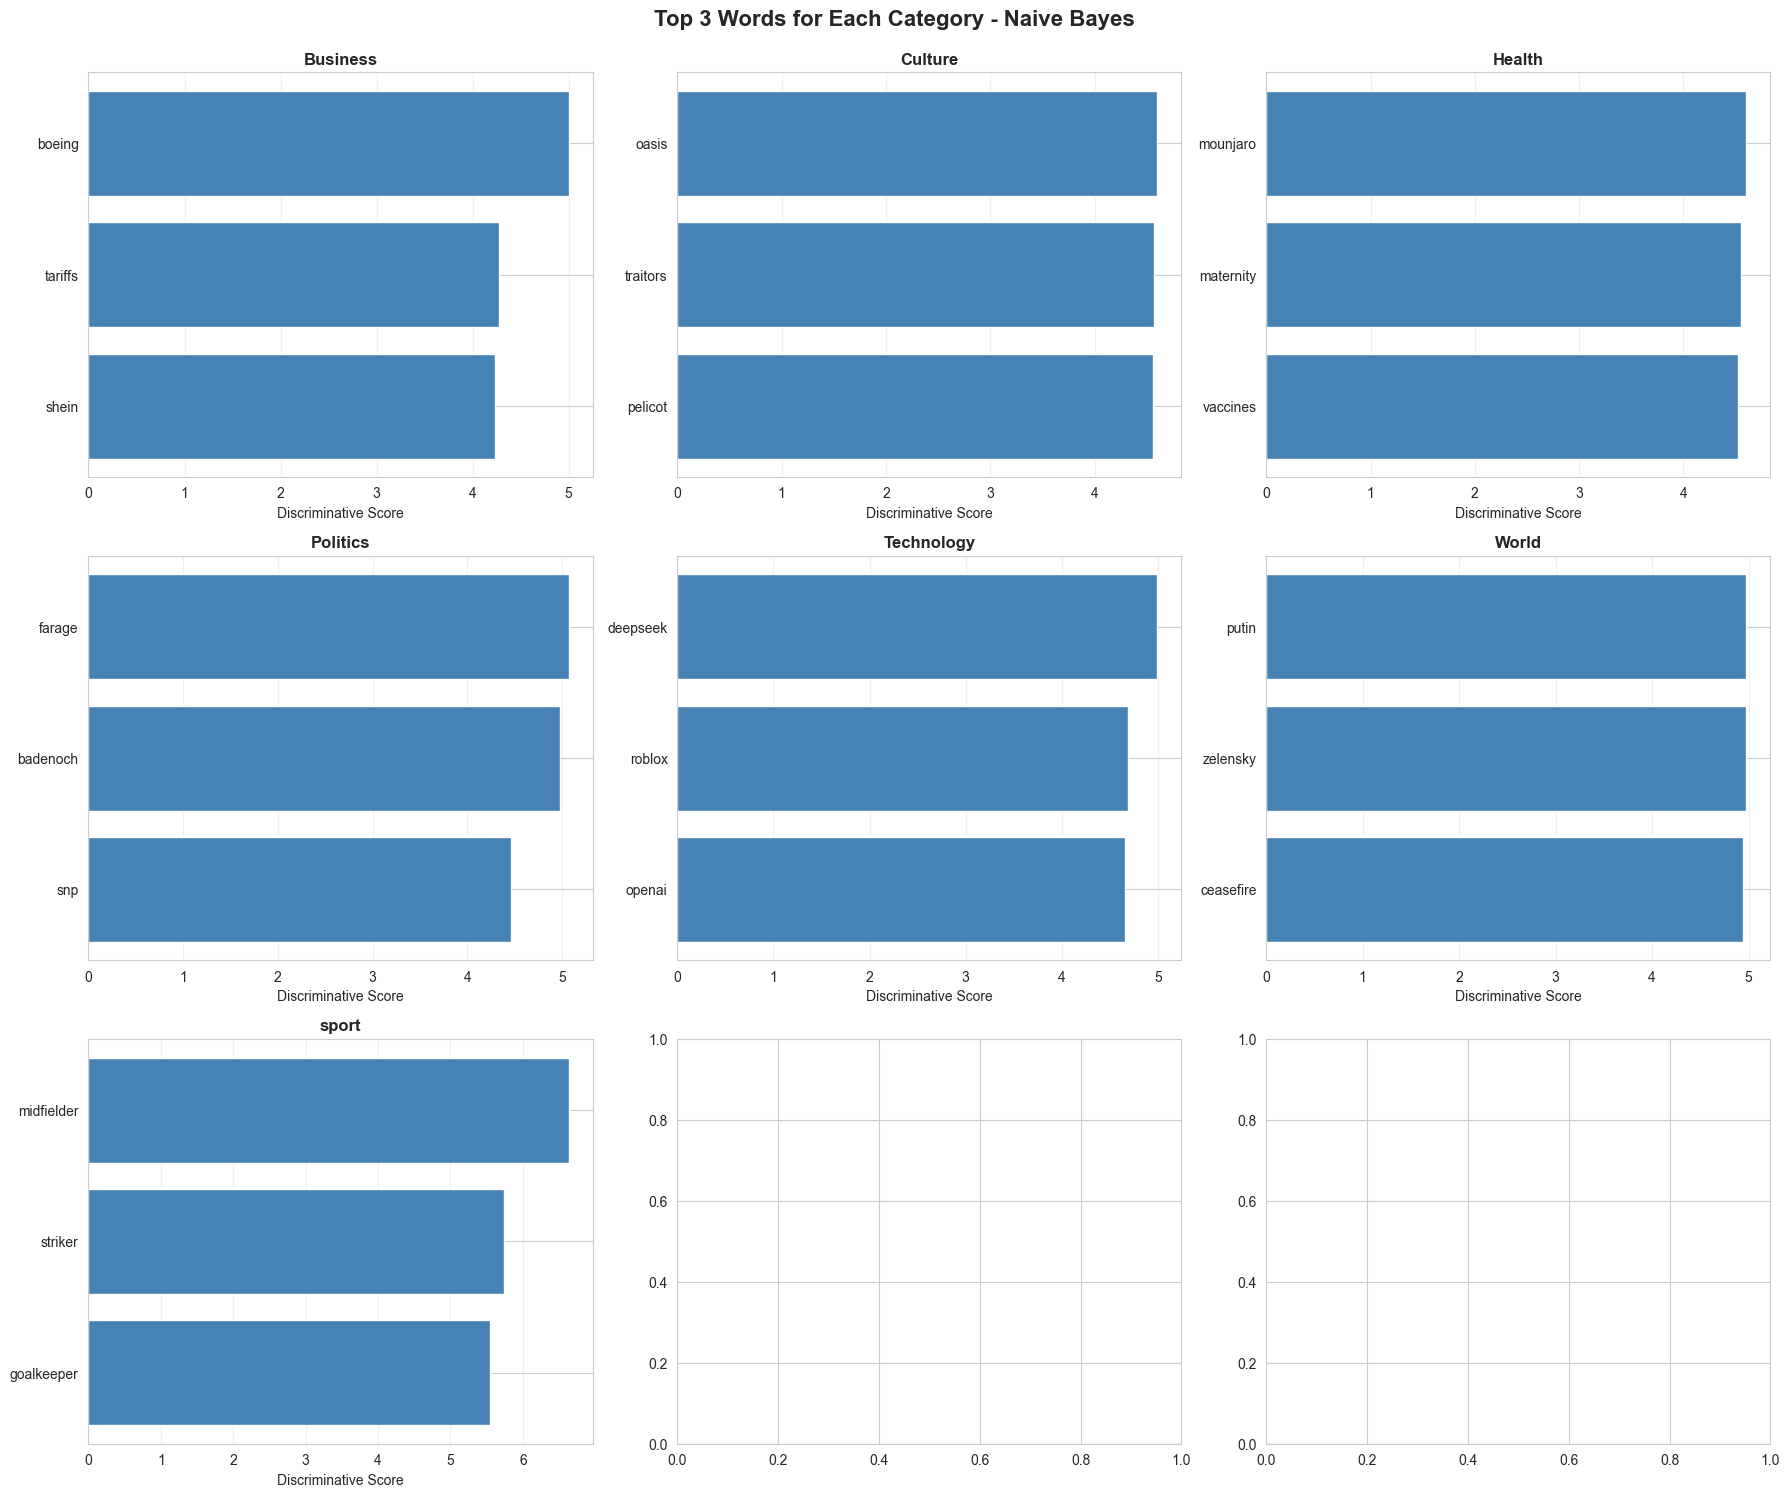

In [42]:
nb_vis_data = []
for category in sorted(nb_top_words.keys()):
    for word, score in nb_top_words[category]:
        nb_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'Naive Bayes'
        })

nb_vis_df = pd.DataFrame(nb_vis_data)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(nb_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = nb_vis_df[nb_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='steelblue')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Discriminative Score', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - Naive Bayes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


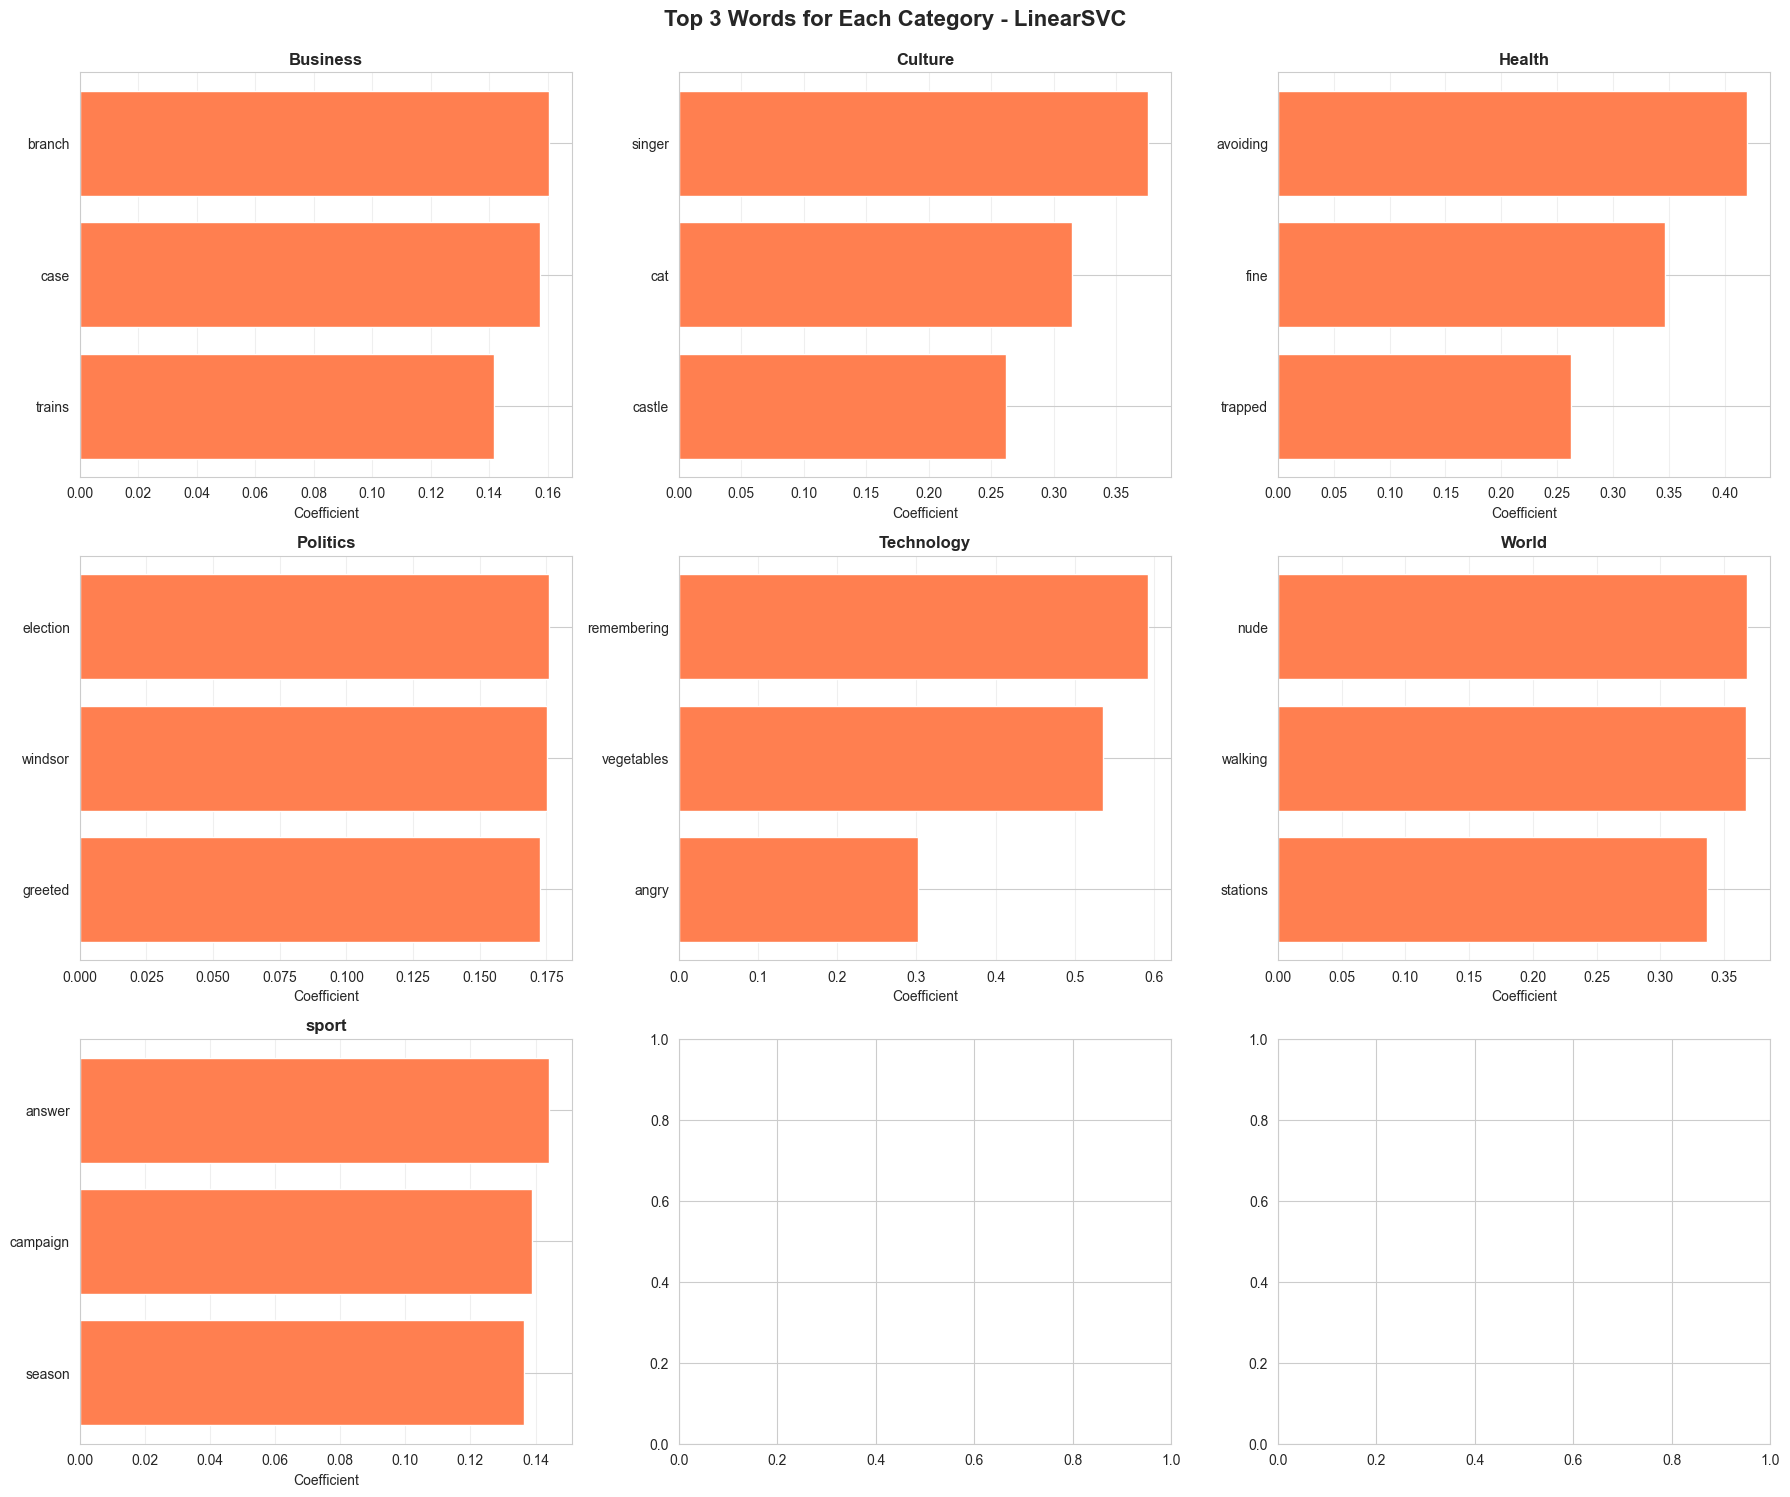

In [43]:
svc_vis_data = []
for category in sorted(svc_top_words.keys()):
    for word, score in svc_top_words[category]:
        svc_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'LinearSVC'
        })

svc_vis_df = pd.DataFrame(svc_vis_data)


fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(svc_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = svc_vis_df[svc_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='coral')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Coefficient', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - LinearSVC', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [44]:
comparison_data = []
for category in sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys()))):
    nb_words = [w[0] for w in nb_top_words.get(category, [])]
    svc_words = [w[0] for w in svc_top_words.get(category, [])]
    
    comparison_data.append({
        'Category': category,
        'Naive Bayes - Top 3': ', '.join(nb_words) if nb_words else 'N/A',
        'LinearSVC - Top 3': ', '.join(svc_words) if svc_words else 'N/A',
        'Common Words': ', '.join(set(nb_words) & set(svc_words)) if (nb_words and svc_words) else 'None'
    })

comparison_df = pd.DataFrame(comparison_data)

styled_comparison = comparison_df.style.set_caption('Top 3 Words Comparison Between Models').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold'})

display(styled_comparison)


,Category,Naive Bayes - Top 3,LinearSVC - Top 3,Common Words
0,Business,"boeing, tariffs, shein","branch, case, trains",
1,Culture,"oasis, traitors, pelicot","singer, cat, castle",
2,Health,"mounjaro, maternity, vaccines","avoiding, fine, trapped",
3,Politics,"farage, badenoch, snp","election, windsor, greeted",
4,Technology,"deepseek, roblox, openai","remembering, vegetables, angry",
5,World,"putin, zelensky, ceasefire","nude, walking, stations",
6,sport,"midfielder, striker, goalkeeper","answer, campaign, season",


In [45]:
summary_data = []
categories = sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys())))

for category in categories:
    nb_words = ', '.join([w[0] for w in nb_top_words.get(category, [])])
    svc_words = ', '.join([w[0] for w in svc_top_words.get(category, [])])
    
    summary_data.append({
        'Category': category,
        'Naive Bayes': nb_words if nb_words else 'N/A',
        'LinearSVC': svc_words if svc_words else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style.set_caption('Top 3 Most Important Words for Each Category - Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'th', 'props': [('background-color', '#2E75B6'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold', 'background-color': '#E7F3FF'})

display(styled_summary)


,Category,Naive Bayes,LinearSVC
0,Business,"boeing, tariffs, shein","branch, case, trains"
1,Culture,"oasis, traitors, pelicot","singer, cat, castle"
2,Health,"mounjaro, maternity, vaccines","avoiding, fine, trapped"
3,Politics,"farage, badenoch, snp","election, windsor, greeted"
4,Technology,"deepseek, roblox, openai","remembering, vegetables, angry"
5,World,"putin, zelensky, ceasefire","nude, walking, stations"
6,sport,"midfielder, striker, goalkeeper","answer, campaign, season"


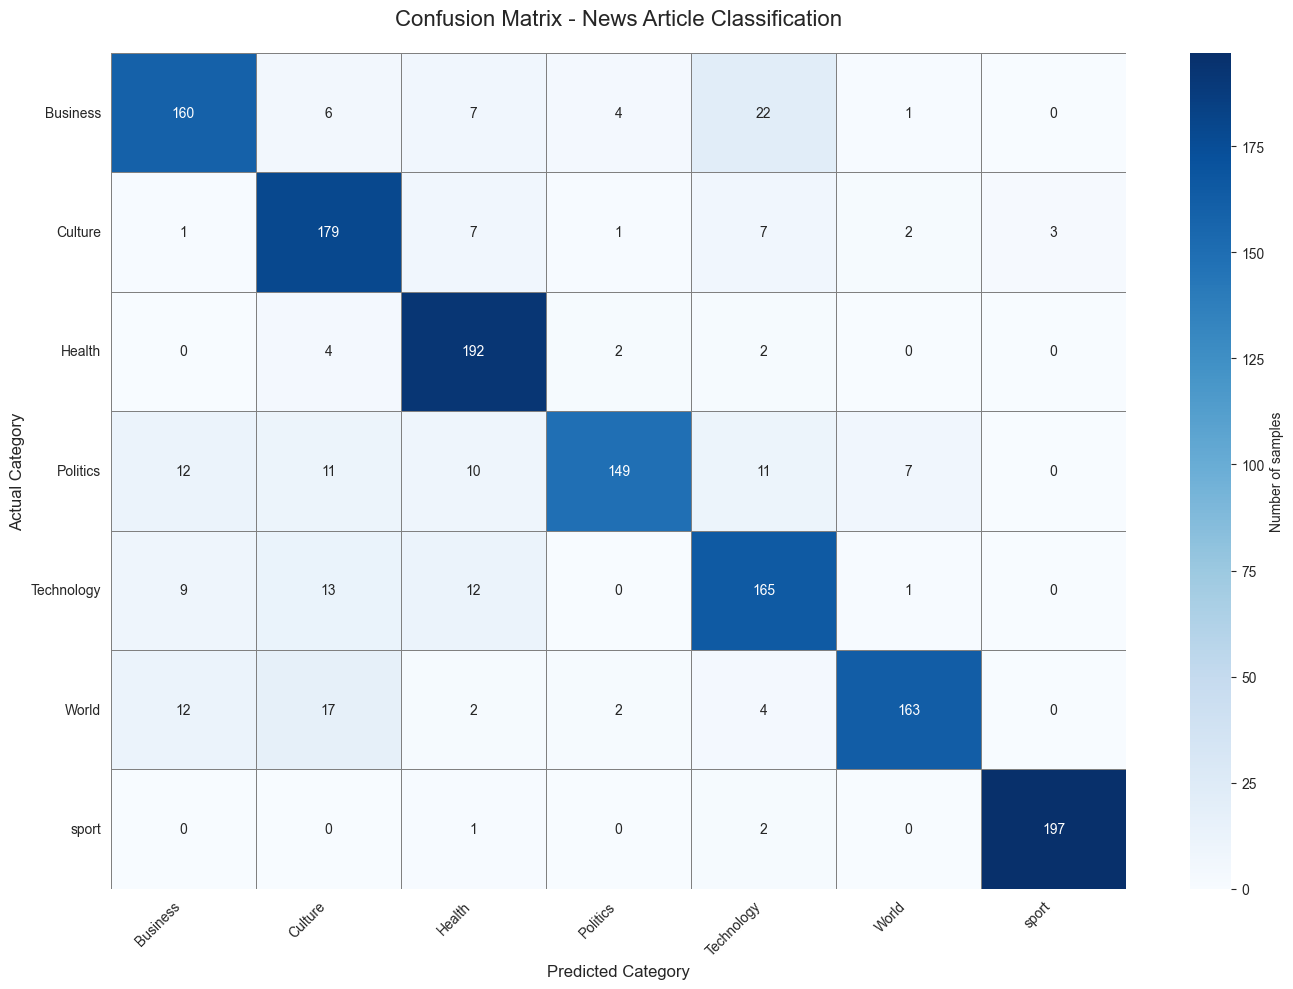

In [46]:
from sklearn.utils.multiclass import unique_labels

labels = list(unique_labels(y_test, predictions))
cm = confusion_matrix(y_test, predictions, labels=labels)
categories = labels

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar_kws={'label': 'Number of samples'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Confusion Matrix - News Article Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

